In [13]:
# %pip install -q torch

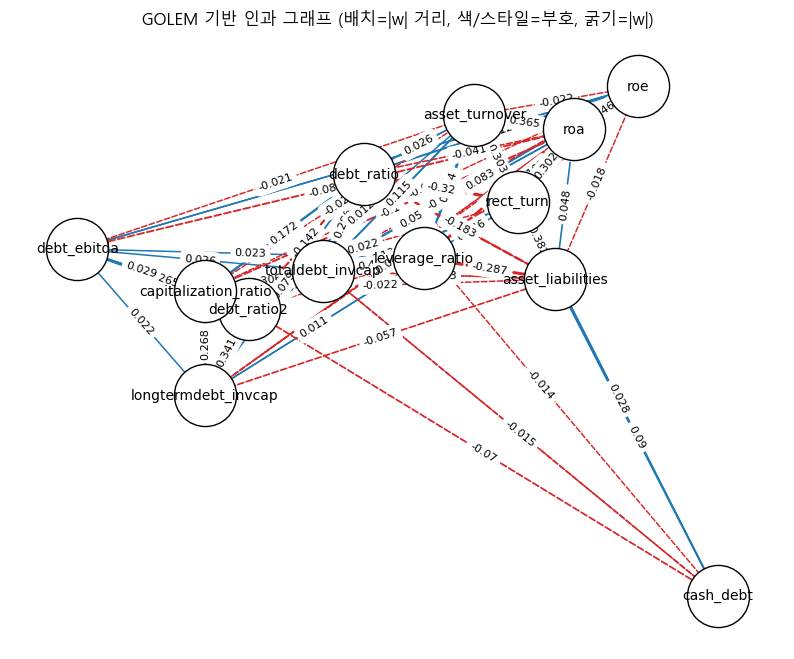

In [14]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

# --- 시각화 설정 (선택) ---
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# 0) 데이터 로드 (기존과 동일: df, feature_cols, X_base, y, cols_for_w, cols)
df = pd.read_csv("training_data.csv")
feature_cols = df.drop(columns=["Unnamed: 0", "label"]).columns
X_base = df[feature_cols].copy()
y = df["label"].astype(int)
cols_for_w = list(feature_cols)
cols = cols_for_w

# 1) 표준화 데이터 (GOLEM은 연속 최적화에서 스케일 영향 ↓)
Z = StandardScaler().fit_transform(X_base.values)  # (n, d)
n, d = Z.shape

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_t = torch.tensor(Z, dtype=torch.float32, device=device)

# 2) GOLEM(EV) 목적함수 구성
#    - 재구성오차(0.5/n ||X - XW||_F^2)
#    - L1 (sparsity), L2 (ridge)
#    - 비순환 제약: h(W)=tr(exp(W∘W)) - d  (∘: elementwise)
#    - Augmented Lagrangian: μ*h + (ρ/2)h^2
lambda1 = 2e-2   # L1 sparsity (필요시 조정)
lambda2 = 5e-2   # L2 ridge     (필요시 조정)
lr = 2e-2
inner_steps = 1500   # 내부(Adam) 반복
max_outer = 8        # 바깥(라그랑주/패널티 갱신) 반복
h_tol = 1e-8
mu = 1.0
rho = 1.0

W_param = nn.Parameter(torch.zeros(d, d, device=device))
I = torch.eye(d, device=device)
mask_offdiag = (1.0 - torch.eye(d, device=device))  # 대각선 0 유지용 마스크
optimizer = optim.Adam([W_param], lr=lr)

def acyclicity(W_eff: torch.Tensor) -> torch.Tensor:
    M = W_eff * W_eff  # elementwise square
    return torch.trace(torch.matrix_exp(M)) - d

def loss_fn(W_eff: torch.Tensor) -> torch.Tensor:
    # 재구성오차
    recon = 0.5 / n * torch.sum((X_t - X_t @ W_eff) ** 2)
    # 정규화
    l1 = lambda1 * torch.sum(torch.abs(W_eff))
    l2 = 0.5 * lambda2 * torch.sum(W_eff ** 2)
    # 비순환
    h = acyclicity(W_eff)
    aug = mu * h + 0.5 * rho * h * h
    return recon + l1 + l2 + aug, h, recon

best_loss = float('inf')
with torch.enable_grad():
    for outer in range(max_outer):
        for step in range(inner_steps):
            optimizer.zero_grad()
            W_eff = W_param * mask_offdiag  # 대각 0 강제
            loss, h_val, recon = loss_fn(W_eff)
            loss.backward()
            optimizer.step()

            # 대각 0 강제(수치오차 cleanup)
            with torch.no_grad():
                W_param.data = W_param.data * mask_offdiag

            if loss.item() < best_loss:
                best_loss = loss.item()

        # AugLag 업데이트
        with torch.no_grad():
            W_eff = W_param * mask_offdiag
            h_curr = acyclicity(W_eff).item()
        if h_curr <= h_tol:
            # 충분히 DAG에 가까우면 종료
            break
        mu = mu + rho * h_curr
        rho *= 10.0  # 점진적 패널티 강화

# 3) 결과 행렬 W 추출 (numpy)
W_golem = (W_param * mask_offdiag).detach().cpu().numpy()

# 4) 시각화 파라미터
USE_QUANTILE = False     # True면 분위수 임계 사용
W_THRESHOLD = 0.01       # |W| > 0.01
W_ABS_QUANTILE = 0.90    # USE_QUANTILE=True일 때 상위 10%

def get_threshold(W, fixed=W_THRESHOLD, use_q=USE_QUANTILE, q=W_ABS_QUANTILE):
    if not use_q:
        return fixed
    aw = np.abs(W).ravel()
    aw = aw[aw > 0]
    return float(np.quantile(aw, q)) if aw.size else fixed

thr = get_threshold(W_golem)

# 5) 그래프 구성 (부호 유지), 레이아웃은 |w| 기반 양의 '거리'로 안정화
G = nx.DiGraph()
edges_all = []
for i in range(d):
    for j in range(d):
        if i == j:
            continue
        w = float(W_golem[i, j])  # i <- j
        if abs(w) > thr:
            u = cols[j]  # parent
            v = cols[i]  # child
            edges_all.append((u, v, w))
            G.add_edge(u, v, weight=round(w, 3))

# 배치용 보조 그래프(H): 거리=1/(|w|+ε)
eps = 1e-6
H = nx.Graph()
for u, v, data in G.edges(data=True):
    w = data.get("weight", 0.0)
    dist = 1.0 / (abs(w) + eps)
    H.add_edge(u, v, weight=dist)

pos = nx.kamada_kawai_layout(H, weight='weight')  # 안정적 배치

# 부호/크기 스타일
max_abs = max((abs(d["weight"]) for _, _, d in G.edges(data=True)), default=1.0)
pos_edges = [(u, v) for u, v, d_ in G.edges(data=True) if d_["weight"] >= 0]
neg_edges = [(u, v) for u, v, d_ in G.edges(data=True) if d_["weight"] < 0]
pos_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in pos_edges]
neg_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in neg_edges]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="white", edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, edgelist=pos_edges, edge_color="tab:blue", width=pos_widths, arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=neg_edges, edge_color="tab:red",  width=neg_widths, style="dashed", arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'), font_size=8)
plt.title("GOLEM 기반 인과 그래프 (배치=|w| 거리, 색/스타일=부호, 굵기=|w|)")
plt.axis("off")
plt.show()

W = W_golem


[INFO] W file not found. Using correlation-based fallback for baseline W.
[CSV] saved: baseline_edges_top40.csv (rows=40)
[CSV] saved: randW_edges_top40.csv (rows=40)
[CSV] saved: randEdge_edges_top40.csv (rows=40)


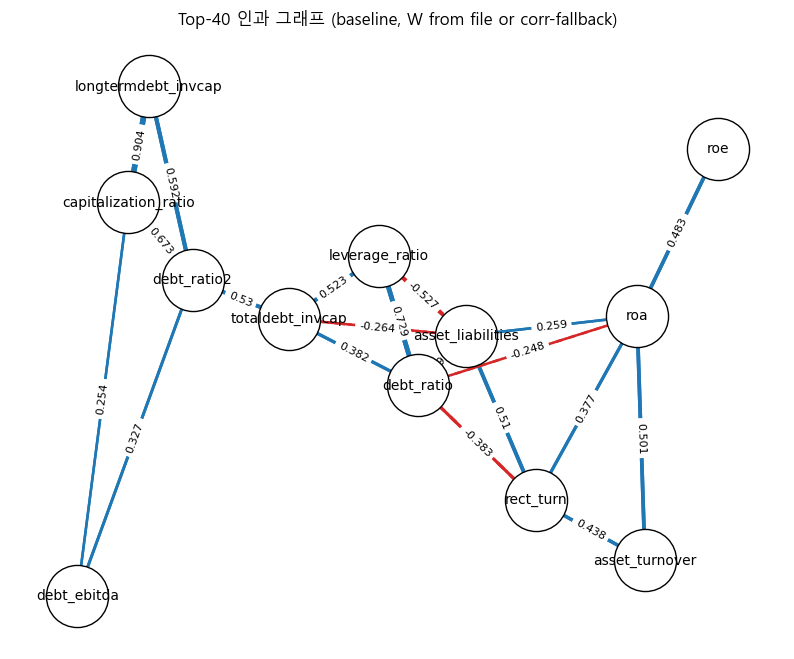

In [15]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Tuple, Dict, Optional

from sklearn.preprocessing import StandardScaler
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import random
import os

# --- 시각화 설정 (선택) ---
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# =========================
# 설정
# =========================
DATA_PATH = "training_data.csv"
ID_COL = "Unnamed: 0"
LABEL_COL = "label"

TOP_K = 40                 # Top-K 엣지 개수
RANDOM_STATE = 42          # 재현성
RANDW_STD = 1.0            # randW 가중치 표준편차 (N(0, RANDW_STD^2))

# =========================
# 0) 데이터 로드
# =========================
df = pd.read_csv(DATA_PATH)
feature_cols = df.drop(columns=[ID_COL, LABEL_COL]).columns
X_base = df[feature_cols].copy()
y = df[LABEL_COL].astype(int)
cols_for_w = list(feature_cols)   # W/엣지에 사용할 컬럼 목록
cols = cols_for_w                 # (호환 변수명)

# =========================
# 1) 표준화
# =========================
Z = StandardScaler().fit_transform(X_base.values)  # (n, d)
n, d = Z.shape

# =========================
# 2) W 불러오기 or 대체 생성 (GOLEM 학습은 하지 않음)
# =========================
def load_W_from_disk(d_expected: int) -> Optional[np.ndarray]:
    """W 후보 파일을 순서대로 찾아 로드. 크기가 맞으면 반환, 아니면 None."""
    candidates = ["W_golem.npy", "W.npy", "W_input.npy"]
    for p in candidates:
        if os.path.exists(p):
            W = np.load(p)
            if isinstance(W, np.ndarray) and W.shape == (d_expected, d_expected):
                np.fill_diagonal(W, 0.0)
                print(f"[INFO] Loaded W from '{p}' with shape {W.shape}")
                return W
            else:
                print(f"[WARN] '{p}' shape {getattr(W, 'shape', None)} != ({d_expected},{d_expected}); ignored.")
    return None

def build_W_by_corr(Z: np.ndarray) -> np.ndarray:
    """
    GOLEM 없이도 실행 가능하도록, 표준화 데이터의 상관행렬을
    단일 회귀(OLS, 무절편) 근사 가중치로 사용.
    W[i,j]는 'j -> i'로 해석 (i <- j). 대각은 0.
    """
    C = np.corrcoef(Z, rowvar=False)  # d x d
    np.fill_diagonal(C, 0.0)
    return C

W_baseline = load_W_from_disk(d)  # 우선 디스크에서 로드 시도
if W_baseline is None:
    print("[INFO] W file not found. Using correlation-based fallback for baseline W.")
    W_baseline = build_W_by_corr(Z)

# =========================
# 유틸: Top-K 추출/CSV 저장
# =========================
def pick_top_k_pairs_ij(W: np.ndarray, K: int) -> List[Tuple[int, int]]:
    """|W[i,j]| 상위 K개 (i=child, j=parent) 인덱스 쌍 반환"""
    n = W.shape[0]
    flat = []
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            w = W[i, j]
            if w == 0.0:
                continue
            flat.append((i, j, abs(w)))
    flat.sort(key=lambda t: t[2], reverse=True)
    pairs = [(i, j) for (i, j, _) in flat[:K]]
    return pairs

def edges_uv_from_pairs(pairs_ij: List[Tuple[int,int]]) -> List[Tuple[int,int]]:
    """(i(child), j(parent)) → (u=parent=j, v=child=i)"""
    return [(j, i) for (i, j) in pairs_ij]

def save_edges_to_csv(W: np.ndarray,
                      edges_uv: List[Tuple[int,int]],
                      cols: List[str],
                      csv_path: str,
                      weights_override: Optional[Dict[Tuple[int,int], float]] = None):
    """
    |출발노드|가중치|도착노드| 저장
    edges_uv: (u=parent, v=child)
    weights_override가 있으면 그 값 사용, 없으면 W[v,u] 사용
    """
    assert len(cols) == W.shape[0], "cols 길이와 W 차원이 일치해야 합니다."
    rows = []
    for (u, v) in edges_uv:
        w = weights_override[(u, v)] if (weights_override is not None and (u, v) in weights_override) else float(W[v, u])
        rows.append({
            "출발노드": cols[u],
            "가중치": float(w),
            "도착노드": cols[v],
        })
    pd.DataFrame(rows, columns=["출발노드","가중치","도착노드"]).to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"[CSV] saved: {csv_path} (rows={len(rows)})")

# =========================
# 3) baseline: Top-K 먼저 고정 (W_baseline 기준)
# =========================
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

baseline_pairs_ij = pick_top_k_pairs_ij(W_baseline, TOP_K)       # (i, j)
baseline_edges_uv = edges_uv_from_pairs(baseline_pairs_ij)       # (u, v)=(parent, child)
baseline_weights  = {(u, v): float(W_baseline[v, u]) for (u, v) in baseline_edges_uv}

save_edges_to_csv(W_baseline, baseline_edges_uv, cols, f"baseline_edges_top{TOP_K}.csv", weights_override=baseline_weights)

# =========================
# 4) randW: 엣지는 baseline Top-K 유지, 가중치만 N(0, RANDW_STD^2)
# =========================
rng = np.random.default_rng(RANDOM_STATE + 777)
W_randW = np.zeros_like(W_baseline)
for (u, v) in baseline_edges_uv:
    W_randW[v, u] = rng.normal(0.0, RANDW_STD)

randW_edges_uv = baseline_edges_uv  # 엣지 집합 동일
randW_weights  = {(u, v): float(W_randW[v, u]) for (u, v) in randW_edges_uv}
save_edges_to_csv(W_randW, randW_edges_uv, cols, f"randW_edges_top{TOP_K}.csv", weights_override=randW_weights)

# =========================
# 5) randEdge: 엣지+가중치 모두 무작위 (엣지 수=Top-K)
# =========================
rng2 = np.random.default_rng(RANDOM_STATE + 999)
candidates = [(u, v) for u in range(d) for v in range(d) if u != v]
chosen_idx = rng2.choice(len(candidates), size=min(TOP_K, len(candidates)), replace=False)
randEdge_edges_uv = [candidates[idx] for idx in chosen_idx]

W_randEdge = np.zeros_like(W_baseline)
for (u, v) in randEdge_edges_uv:
    W_randEdge[v, u] = rng2.normal(0.0, RANDW_STD)

randEdge_weights = {(u, v): float(W_randEdge[v, u]) for (u, v) in randEdge_edges_uv}
save_edges_to_csv(W_randEdge, randEdge_edges_uv, cols, f"randEdge_edges_top{TOP_K}.csv", weights_override=randEdge_weights)

# =========================
# (선택) baseline 그래프 시각화
# =========================
G = nx.DiGraph()
for (u, v) in baseline_edges_uv:
    w = baseline_weights[(u, v)]
    G.add_edge(cols[u], cols[v], weight=round(w, 3))

# 배치용 보조 그래프(H): 거리=1/(|w|+ε)
eps = 1e-6
H = nx.Graph()
for u, v, data in G.edges(data=True):
    w = data.get("weight", 0.0)
    dist = 1.0 / (abs(w) + eps)
    H.add_edge(u, v, weight=dist)

pos = nx.kamada_kawai_layout(H, weight='weight')
max_abs = max((abs(d_["weight"]) for _, _, d_ in G.edges(data=True)), default=1.0)
pos_edges = [(u, v) for u, v, d_ in G.edges(data=True) if d_["weight"] >= 0]
neg_edges = [(u, v) for u, v, d_ in G.edges(data=True) if d_["weight"] < 0]
pos_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in pos_edges]
neg_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in neg_edges]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="white", edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, edgelist=pos_edges, edge_color="tab:blue", width=pos_widths, arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=neg_edges, edge_color="tab:red",  width=neg_widths, style="dashed", arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'), font_size=8)
plt.title(f"Top-{TOP_K} 인과 그래프 (baseline, W from file or corr-fallback)")
plt.axis("off")
plt.show()

# 호환 변수
W = W_baseline


[GOLEM] outer=1/8, h=1.692e-01, best_loss=3.634417
[GOLEM] outer=2/8, h=9.340e-02, best_loss=3.634417
[GOLEM] outer=3/8, h=3.478e-02, best_loss=3.634417
[GOLEM] outer=4/8, h=9.713e-03, best_loss=3.634417
[GOLEM] outer=5/8, h=2.401e-03, best_loss=3.634417
[GOLEM] outer=6/8, h=6.285e-04, best_loss=3.634417
[GOLEM] outer=7/8, h=1.431e-04, best_loss=3.634417
[GOLEM] outer=8/8, h=5.817e-05, best_loss=3.634417
[CSV] saved: runs_golem_lightgbm_40\baseline_edges_top40.csv (rows=40)
[CSV] saved: runs_golem_lightgbm_40\randW_edges_top40.csv (rows=40)
[CSV] saved: runs_golem_lightgbm_40\randEdge_edges_top40.csv (rows=40)
[baseline:O] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3030
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[106]	valid_0's auc: 0.920933	valid_0's binary_logloss: 0.0914904
[baseline:O] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3025
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[82]	valid_0's auc: 0.953858	valid_0's binary_logloss: 0.105681
[baseline:O] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3034
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[70]	valid_0's auc: 0.928164	valid_0's binary_logloss: 0.121308
[baseline:O] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3032
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[130]	valid_0's auc: 0.939224	valid_0's binary_logloss: 0.0781649
[baseline:O] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3026
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[12]	valid_0's auc: 0.934356	valid_0's binary_logloss: 0.404145
[baseline:O] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3033
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[92]	valid_0's auc: 0.948507	valid_0's binary_logloss: 0.0898579
[baseline:O] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3029
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[39]	valid_0's auc: 0.925967	valid_0's binary_logloss: 0.198154
[baseline:O] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3025
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[148]	valid_0's auc: 0.924012	valid_0's binary_logloss: 0.080701
[baseline:O] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3033
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[64]	valid_0's auc: 0.927801	valid_0's binary_logloss: 0.132482
[baseline:F(m)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[40]	valid_0's auc: 0.934423	valid_0's binary_logloss: 0.16219
[baseline:F(m)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[30]	valid_0's auc: 0.916274	valid_0's binary_logloss: 0.212722
[baseline:F(m)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[112]	valid_0's auc: 0.947608	valid_0's binary_logloss: 0.0695247
[baseline:F(m)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[111]	valid_0's auc: 0.935228	valid_0's binary_logloss: 0.0773827
[baseline:F(m)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[106]	valid_0's auc: 0.940633	valid_0's binary_logloss: 0.0815849
[baseline:F(m)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[135]	valid_0's auc: 0.929537	valid_0's binary_logloss: 0.0669774
[baseline:F(m)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[95]	valid_0's auc: 0.948302	valid_0's binary_logloss: 0.0732731
[baseline:F(m)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[165]	valid_0's auc: 0.931806	valid_0's binary_logloss: 0.0743844
[baseline:F(m)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[178]	valid_0's auc: 0.936137	valid_0's binary_logloss: 0.0659363
[baseline:F(m)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[63]	valid_0's auc: 0.919927	valid_0's binary_logloss: 0.114731
[baseline:OF(m)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13230
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[96]	valid_0's auc: 0.941085	valid_0's binary_logloss: 0.0750145
[baseline:OF(m)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13226
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[158]	valid_0's auc: 0.92675	valid_0's binary_logloss: 0.0707329
[baseline:OF(m)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13225
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[78]	valid_0's auc: 0.951465	valid_0's binary_logloss: 0.0883488
[baseline:OF(m)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13234
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[112]	valid_0's auc: 0.937971	valid_0's binary_logloss: 0.0735198
[baseline:OF(m)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13232
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[119]	valid_0's auc: 0.933752	valid_0's binary_logloss: 0.0791624
[baseline:OF(m)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13226
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[64]	valid_0's auc: 0.933009	valid_0's binary_logloss: 0.104009
[baseline:OF(m)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13233
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[72]	valid_0's auc: 0.949094	valid_0's binary_logloss: 0.0910015
[baseline:OF(m)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13229
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[30]	valid_0's auc: 0.926253	valid_0's binary_logloss: 0.211913
[baseline:OF(m)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13225
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[117]	valid_0's auc: 0.93253	valid_0's binary_logloss: 0.0714415
[baseline:OF(m)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13233
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[70]	valid_0's auc: 0.924669	valid_0's binary_logloss: 0.105007
[baseline:F(mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[48]	valid_0's auc: 0.936477	valid_0's binary_logloss: 0.135904
[baseline:F(mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[166]	valid_0's auc: 0.918969	valid_0's binary_logloss: 0.0747195
[baseline:F(mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[121]	valid_0's auc: 0.950418	valid_0's binary_logloss: 0.0657093
[baseline:F(mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[109]	valid_0's auc: 0.934477	valid_0's binary_logloss: 0.0769627
[baseline:F(mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[111]	valid_0's auc: 0.939291	valid_0's binary_logloss: 0.0795701
[baseline:F(mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[94]	valid_0's auc: 0.92471	valid_0's binary_logloss: 0.0797049
[baseline:F(mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[79]	valid_0's auc: 0.944445	valid_0's binary_logloss: 0.0835066
[baseline:F(mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[35]	valid_0's auc: 0.92307	valid_0's binary_logloss: 0.18798
[baseline:F(mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[161]	valid_0's auc: 0.936615	valid_0's binary_logloss: 0.0674201
[baseline:F(mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[5]	valid_0's auc: 0.918215	valid_0's binary_logloss: 0.532458
[baseline:OF(mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13230
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[49]	valid_0's auc: 0.940033	valid_0's binary_logloss: 0.135126
[baseline:OF(mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13226
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[159]	valid_0's auc: 0.928007	valid_0's binary_logloss: 0.071485
[baseline:OF(mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13225
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[40]	valid_0's auc: 0.950496	valid_0's binary_logloss: 0.165382
[baseline:OF(mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13234
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[48]	valid_0's auc: 0.934703	valid_0's binary_logloss: 0.142997
[baseline:OF(mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13232
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[117]	valid_0's auc: 0.935913	valid_0's binary_logloss: 0.0772757
[baseline:OF(mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13226
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[41]	valid_0's auc: 0.935935	valid_0's binary_logloss: 0.157572
[baseline:OF(mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13233
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[143]	valid_0's auc: 0.952883	valid_0's binary_logloss: 0.0621394
[baseline:OF(mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13229
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[52]	valid_0's auc: 0.92607	valid_0's binary_logloss: 0.132119
[baseline:OF(mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13225
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[190]	valid_0's auc: 0.934539	valid_0's binary_logloss: 0.0659549
[baseline:OF(mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13233
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[56]	valid_0's auc: 0.934007	valid_0's binary_logloss: 0.123137
[baseline:F(m+mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[80]	valid_0's auc: 0.930566	valid_0's binary_logloss: 0.0888309
[baseline:F(m+mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[5]	valid_0's auc: 0.888888	valid_0's binary_logloss: 0.529724
[baseline:F(m+mw)] fold 3/10 ...


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[113]	valid_0's auc: 0.947469	valid_0's binary_logloss: 0.0681543
[baseline:F(m+mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[13]	valid_0's auc: 0.909972	valid_0's binary_logloss: 0.378411
[baseline:F(m+mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[123]	valid_0's auc: 0.936817	valid_0's binary_logloss: 0.0802275
[baseline:F(m+mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[22]	valid_0's auc: 0.918661	valid_0's binary_logloss: 0.273034
[baseline:F(m+mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[65]	valid_0's auc: 0.944347	valid_0's binary_logloss: 0.0994903
[baseline:F(m+mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[51]	valid_0's auc: 0.916871	valid_0's binary_logloss: 0.138474
[baseline:F(m+mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[136]	valid_0's auc: 0.936356	valid_0's binary_logloss: 0.0693994
[baseline:F(m+mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[21]	valid_0's auc: 0.922942	valid_0's binary_logloss: 0.283315
[baseline:OF(m+mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23430
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[97]	valid_0's auc: 0.930544	valid_0's binary_logloss: 0.0774293
[baseline:OF(m+mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23426
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[161]	valid_0's auc: 0.919399	valid_0's binary_logloss: 0.0716871
[baseline:OF(m+mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23425
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[122]	valid_0's auc: 0.949935	valid_0's binary_logloss: 0.0650555
[baseline:OF(m+mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23434
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[128]	valid_0's auc: 0.938459	valid_0's binary_logloss: 0.0716113
[baseline:OF(m+mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23432
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[164]	valid_0's auc: 0.931917	valid_0's binary_logloss: 0.0762407
[baseline:OF(m+mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23426
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[112]	valid_0's auc: 0.935474	valid_0's binary_logloss: 0.0689005
[baseline:OF(m+mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23433
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[164]	valid_0's auc: 0.946422	valid_0's binary_logloss: 0.0638616
[baseline:OF(m+mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23429
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[17]	valid_0's auc: 0.92462	valid_0's binary_logloss: 0.319582
[baseline:OF(m+mw)] fold 9/10 ...


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23425
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[97]	valid_0's auc: 0.931828	valid_0's binary_logloss: 0.0759979
[baseline:OF(m+mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23433
[LightGBM] [Info] Number of data points in th

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[145]	valid_0's auc: 0.921054	valid_0's binary_logloss: 0.0769508
[CSV] saved: runs_golem_lightgbm_40\baseline_report.csv
[randW:F(m)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[40]	valid_0's auc: 0.934423	valid_0's binary_logloss: 0.16219
[randW:F(m)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[30]	valid_0's auc: 0.916274	valid_0's binary_logloss: 0.212722
[randW:F(m)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[112]	valid_0's auc: 0.947608	valid_0's binary_logloss: 0.0695247
[randW:F(m)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[111]	valid_0's auc: 0.935228	valid_0's binary_logloss: 0.0773827
[randW:F(m)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[106]	valid_0's auc: 0.940633	valid_0's binary_logloss: 0.0815849
[randW:F(m)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[135]	valid_0's auc: 0.929537	valid_0's binary_logloss: 0.0669774
[randW:F(m)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[95]	valid_0's auc: 0.948302	valid_0's binary_logloss: 0.0732731
[randW:F(m)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[165]	valid_0's auc: 0.931806	valid_0's binary_logloss: 0.0743844
[randW:F(m)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[178]	valid_0's auc: 0.936137	valid_0's binary_logloss: 0.0659363
[randW:F(m)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[63]	valid_0's auc: 0.919927	valid_0's binary_logloss: 0.114731
[randW:OF(m)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13230
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[96]	valid_0's auc: 0.941085	valid_0's binary_logloss: 0.0750145
[randW:OF(m)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13226
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[158]	valid_0's auc: 0.92675	valid_0's binary_logloss: 0.0707329
[randW:OF(m)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13225
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[78]	valid_0's auc: 0.951465	valid_0's binary_logloss: 0.0883488
[randW:OF(m)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13234
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[112]	valid_0's auc: 0.937971	valid_0's binary_logloss: 0.0735198
[randW:OF(m)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13232
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[119]	valid_0's auc: 0.933752	valid_0's binary_logloss: 0.0791624
[randW:OF(m)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13226
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[64]	valid_0's auc: 0.933009	valid_0's binary_logloss: 0.104009
[randW:OF(m)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13233
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[72]	valid_0's auc: 0.949094	valid_0's binary_logloss: 0.0910015
[randW:OF(m)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13229
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[30]	valid_0's auc: 0.926253	valid_0's binary_logloss: 0.211913
[randW:OF(m)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13225
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[117]	valid_0's auc: 0.93253	valid_0's binary_logloss: 0.0714415
[randW:OF(m)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13233
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[70]	valid_0's auc: 0.924669	valid_0's binary_logloss: 0.105007
[randW:F(mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[48]	valid_0's auc: 0.93857	valid_0's binary_logloss: 0.13641
[randW:F(mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[165]	valid_0's auc: 0.919994	valid_0's binary_logloss: 0.0736746
[randW:F(mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[118]	valid_0's auc: 0.94997	valid_0's binary_logloss: 0.0677007
[randW:F(mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[122]	valid_0's auc: 0.938825	valid_0's binary_logloss: 0.074299
[randW:F(mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[105]	valid_0's auc: 0.93747	valid_0's binary_logloss: 0.0825615
[randW:F(mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10199
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[88]	valid_0's auc: 0.931716	valid_0's binary_logloss: 0.0822628
[randW:F(mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[78]	valid_0's auc: 0.953263	valid_0's binary_logloss: 0.0828374
[randW:F(mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[129]	valid_0's auc: 0.924383	valid_0's binary_logloss: 0.0783904
[randW:F(mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[123]	valid_0's auc: 0.937631	valid_0's binary_logloss: 0.0689285
[randW:F(mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[31]	valid_0's auc: 0.921593	valid_0's binary_logloss: 0.211213
[randW:OF(mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13230
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[32]	valid_0's auc: 0.93532	valid_0's binary_logloss: 0.197514
[randW:OF(mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13226
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[172]	valid_0's auc: 0.927	valid_0's binary_logloss: 0.071369
[randW:OF(mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13225
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[120]	valid_0's auc: 0.949984	valid_0's binary_logloss: 0.0651415
[randW:OF(mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13234
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[119]	valid_0's auc: 0.940561	valid_0's binary_logloss: 0.0721361
[randW:OF(mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13232
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[129]	valid_0's auc: 0.932298	valid_0's binary_logloss: 0.0759745
[randW:OF(mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13225
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[53]	valid_0's auc: 0.941644	valid_0's binary_logloss: 0.122125
[randW:OF(mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13233
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[84]	valid_0's auc: 0.948628	valid_0's binary_logloss: 0.0793952
[randW:OF(mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13229
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[12]	valid_0's auc: 0.916278	valid_0's binary_logloss: 0.387399
[randW:OF(mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13225
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[90]	valid_0's auc: 0.939371	valid_0's binary_logloss: 0.0784742
[randW:OF(mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13233
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[106]	valid_0's auc: 0.920678	valid_0's binary_logloss: 0.0821234
[randW:F(m+mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[66]	valid_0's auc: 0.932002	valid_0's binary_logloss: 0.100207
[randW:F(m+mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[134]	valid_0's auc: 0.915198	valid_0's binary_logloss: 0.0764549
[randW:F(m+mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[112]	valid_0's auc: 0.952628	valid_0's binary_logloss: 0.0683419
[randW:F(m+mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[116]	valid_0's auc: 0.935922	valid_0's binary_logloss: 0.0736662
[randW:F(m+mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[170]	valid_0's auc: 0.936298	valid_0's binary_logloss: 0.0757906
[randW:F(m+mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20399
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[100]	valid_0's auc: 0.92756	valid_0's binary_logloss: 0.0764147
[randW:F(m+mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[107]	valid_0's auc: 0.952373	valid_0's binary_logloss: 0.0686892
[randW:F(m+mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[17]	valid_0's auc: 0.92047	valid_0's binary_logloss: 0.320172
[randW:F(m+mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[148]	valid_0's auc: 0.930159	valid_0's binary_logloss: 0.0688739
[randW:F(m+mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[6]	valid_0's auc: 0.912298	valid_0's binary_logloss: 0.506803
[randW:OF(m+mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23430
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[101]	valid_0's auc: 0.927112	valid_0's binary_logloss: 0.0764936
[randW:OF(m+mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23426
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[122]	valid_0's auc: 0.92637	valid_0's binary_logloss: 0.0746092
[randW:OF(m+mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23425
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[22]	valid_0's auc: 0.956319	valid_0's binary_logloss: 0.272468
[randW:OF(m+mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23434
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[100]	valid_0's auc: 0.937922	valid_0's binary_logloss: 0.0789957
[randW:OF(m+mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23432
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[152]	valid_0's auc: 0.929448	valid_0's binary_logloss: 0.0763112
[randW:OF(m+mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23425
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[113]	valid_0's auc: 0.933474	valid_0's binary_logloss: 0.0687288
[randW:OF(m+mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23433
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[83]	valid_0's auc: 0.951308	valid_0's binary_logloss: 0.0797725
[randW:OF(m+mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23429
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[82]	valid_0's auc: 0.920164	valid_0's binary_logloss: 0.0960827
[randW:OF(m+mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23425
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[145]	valid_0's auc: 0.930137	valid_0's binary_logloss: 0.0674344
[randW:OF(m+mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23433
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[160]	valid_0's auc: 0.925537	valid_0's binary_logloss: 0.0748922
[CSV] saved: runs_golem_lightgbm_40\randW_report.csv
[randEdge:F(m)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[70]	valid_0's auc: 0.920857	valid_0's binary_logloss: 0.111256
[randEdge:F(m)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[91]	valid_0's auc: 0.923211	valid_0's binary_logloss: 0.0949603
[randEdge:F(m)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[92]	valid_0's auc: 0.943156	valid_0's binary_logloss: 0.0877707
[randEdge:F(m)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[50]	valid_0's auc: 0.934978	valid_0's binary_logloss: 0.14857
[randEdge:F(m)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[147]	valid_0's auc: 0.930141	valid_0's binary_logloss: 0.0818203
[randEdge:F(m)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[94]	valid_0's auc: 0.924074	valid_0's binary_logloss: 0.0836426
[randEdge:F(m)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[84]	valid_0's auc: 0.944924	valid_0's binary_logloss: 0.0912714
[randEdge:F(m)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[22]	valid_0's auc: 0.907142	valid_0's binary_logloss: 0.290549
[randEdge:F(m)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[82]	valid_0's auc: 0.921989	valid_0's binary_logloss: 0.103774
[randEdge:F(m)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[80]	valid_0's auc: 0.906079	valid_0's binary_logloss: 0.11174
[randEdge:OF(m)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13230
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[106]	valid_0's auc: 0.926029	valid_0's binary_logloss: 0.0769871
[randEdge:OF(m)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13226
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[91]	valid_0's auc: 0.917005	valid_0's binary_logloss: 0.09152
[randEdge:OF(m)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13225
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[38]	valid_0's auc: 0.952539	valid_0's binary_logloss: 0.187091
[randEdge:OF(m)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13234
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[103]	valid_0's auc: 0.928826	valid_0's binary_logloss: 0.0829452
[randEdge:OF(m)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13232
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[156]	valid_0's auc: 0.937649	valid_0's binary_logloss: 0.073489
[randEdge:OF(m)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13226
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[108]	valid_0's auc: 0.925385	valid_0's binary_logloss: 0.0743957
[randEdge:OF(m)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13233
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[106]	valid_0's auc: 0.949223	valid_0's binary_logloss: 0.0725716
[randEdge:OF(m)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13229
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[76]	valid_0's auc: 0.921001	valid_0's binary_logloss: 0.102098
[randEdge:OF(m)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13225
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[130]	valid_0's auc: 0.931018	valid_0's binary_logloss: 0.0779875
[randEdge:OF(m)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13233
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[54]	valid_0's auc: 0.911435	valid_0's binary_logloss: 0.137067
[randEdge:F(mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[22]	valid_0's auc: 0.920558	valid_0's binary_logloss: 0.287668
[randEdge:F(mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[129]	valid_0's auc: 0.928378	valid_0's binary_logloss: 0.0777358
[randEdge:F(mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[8]	valid_0's auc: 0.932468	valid_0's binary_logloss: 0.474851
[randEdge:F(mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[72]	valid_0's auc: 0.939501	valid_0's binary_logloss: 0.108261
[randEdge:F(mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[111]	valid_0's auc: 0.931832	valid_0's binary_logloss: 0.089057
[randEdge:F(mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10199
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[123]	valid_0's auc: 0.91675	valid_0's binary_logloss: 0.0742961
[randEdge:F(mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[123]	valid_0's auc: 0.940266	valid_0's binary_logloss: 0.0727685
[randEdge:F(mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[99]	valid_0's auc: 0.917547	valid_0's binary_logloss: 0.0882355
[randEdge:F(mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[80]	valid_0's auc: 0.918764	valid_0's binary_logloss: 0.107049
[randEdge:F(mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[32]	valid_0's auc: 0.907381	valid_0's binary_logloss: 0.228108
[randEdge:OF(mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13230
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[91]	valid_0's auc: 0.928182	valid_0's binary_logloss: 0.0837905
[randEdge:OF(mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13226
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[128]	valid_0's auc: 0.920656	valid_0's binary_logloss: 0.0803946
[randEdge:OF(mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13225
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[78]	valid_0's auc: 0.948575	valid_0's binary_logloss: 0.0969403
[randEdge:OF(mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13234
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[90]	valid_0's auc: 0.922468	valid_0's binary_logloss: 0.0893236
[randEdge:OF(mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13232
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[133]	valid_0's auc: 0.941188	valid_0's binary_logloss: 0.0747516
[randEdge:OF(mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13225
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[104]	valid_0's auc: 0.918504	valid_0's binary_logloss: 0.0763632
[randEdge:OF(mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13233
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[88]	valid_0's auc: 0.947407	valid_0's binary_logloss: 0.080934
[randEdge:OF(mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13229
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[6]	valid_0's auc: 0.914001	valid_0's binary_logloss: 0.509159
[randEdge:OF(mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13225
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[198]	valid_0's auc: 0.932736	valid_0's binary_logloss: 0.0735131
[randEdge:OF(mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13233
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[60]	valid_0's auc: 0.906876	valid_0's binary_logloss: 0.125941
[randEdge:F(m+mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[20]	valid_0's auc: 0.916267	valid_0's binary_logloss: 0.305349
[randEdge:F(m+mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[64]	valid_0's auc: 0.914983	valid_0's binary_logloss: 0.125924
[randEdge:F(m+mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[138]	valid_0's auc: 0.945711	valid_0's binary_logloss: 0.0686056
[randEdge:F(m+mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[65]	valid_0's auc: 0.936848	valid_0's binary_logloss: 0.119712
[randEdge:F(m+mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[167]	valid_0's auc: 0.928208	valid_0's binary_logloss: 0.0792397
[randEdge:F(m+mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20399
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[112]	valid_0's auc: 0.918951	valid_0's binary_logloss: 0.0778633
[randEdge:F(m+mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[139]	valid_0's auc: 0.938884	valid_0's binary_logloss: 0.0720625
[randEdge:F(m+mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[99]	valid_0's auc: 0.912222	valid_0's binary_logloss: 0.090783
[randEdge:F(m+mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[109]	valid_0's auc: 0.915641	valid_0's binary_logloss: 0.0907615
[randEdge:F(m+mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[56]	valid_0's auc: 0.902299	valid_0's binary_logloss: 0.145685
[randEdge:OF(m+mw)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23430
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[49]	valid_0's auc: 0.926897	valid_0's binary_logloss: 0.141186
[randEdge:OF(m+mw)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23426
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[135]	valid_0's auc: 0.923609	valid_0's binary_logloss: 0.0798778
[randEdge:OF(m+mw)] fold 3/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23425
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[91]	valid_0's auc: 0.952982	valid_0's binary_logloss: 0.0844712
[randEdge:OF(m+mw)] fold 4/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23434
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[90]	valid_0's auc: 0.926302	valid_0's binary_logloss: 0.0905649
[randEdge:OF(m+mw)] fold 5/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23432
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[164]	valid_0's auc: 0.937461	valid_0's binary_logloss: 0.0745946
[randEdge:OF(m+mw)] fold 6/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23425
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[112]	valid_0's auc: 0.925135	valid_0's binary_logloss: 0.0738437
[randEdge:OF(m+mw)] fold 7/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23433
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[121]	valid_0's auc: 0.948798	valid_0's binary_logloss: 0.0692471
[randEdge:OF(m+mw)] fold 8/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23429
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[176]	valid_0's auc: 0.919484	valid_0's binary_logloss: 0.0750604
[randEdge:OF(m+mw)] fold 9/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23425
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[112]	valid_0's auc: 0.927962	valid_0's binary_logloss: 0.0818703
[randEdge:OF(m+mw)] fold 10/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23433
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Early stopping, best iteration is:
[91]	valid_0's auc: 0.919864	valid_0's binary_logloss: 0.0947863
[CSV] saved: runs_golem_lightgbm_40\randEdge_report.csv
[CSV] saved: runs_golem_lightgbm_40\all_reports.csv


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


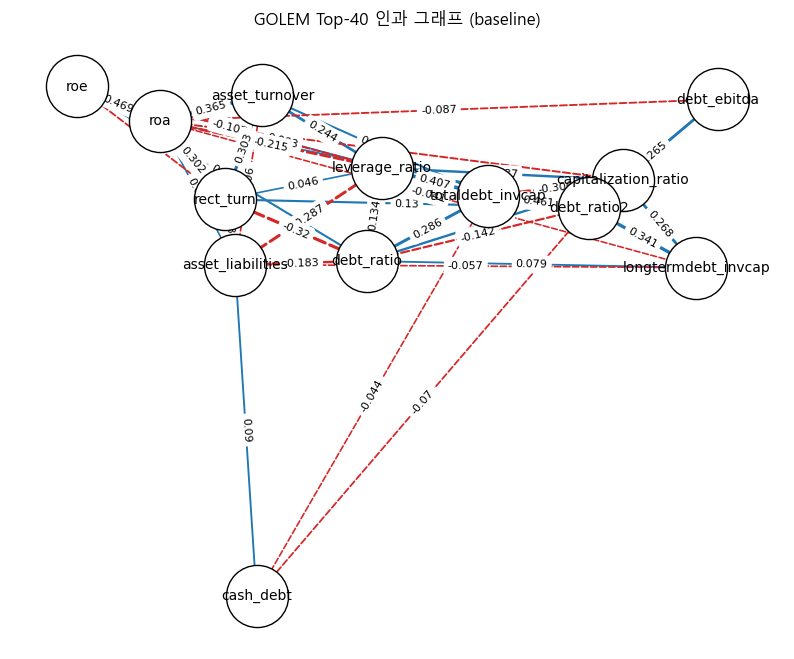

In [16]:
# ============================================================
# GOLEM 학습 → Top-K 고정 → randW / randEdge → LGBM CV Report
# 저장 경로: runs_golem_lightgbm_35/
# 산출물:
#   - baseline_edges_top{K}.csv
#   - randW_edges_top{K}.csv
#   - randEdge_edges_top{K}.csv
#   - baseline_report.csv, randW_report.csv, randEdge_report.csv
#   - all_reports.csv (통합)
# ============================================================

import os, random
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Tuple, Dict, Optional

# ML / CV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, brier_score_loss
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# GOLEM (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim

# (선택) 시각화
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# ------------------ 설정 ------------------
DATA_PATH   = "training_data.csv"
ID_COL      = "Unnamed: 0"
LABEL_COL   = "label"

TOP_K       = 40       # Top-K 엣지 수
RANDOM_STATE= 42
RANDW_STD   = 1.0      # randW, randEdge 가중치 표준편차 (N(0, RANDW_STD^2))

PRINT_PROGRESS = True

LGBM_PARAMS = dict(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=63,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective="binary",
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
EARLY_STOPPING_ROUNDS = 50

# GOLEM 하이퍼파라미터
lambda1 = 2e-2   # L1 sparsity
lambda2 = 5e-2   # L2 ridge
lr = 2e-2
inner_steps = 1500
max_outer   = 8
h_tol       = 1e-8
mu0, rho0   = 1.0, 1.0
# -----------------------------------------

# 저장 경로
OUT_DIR = Path("runs_golem_lightgbm_40")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 고정 시드
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

# 0) 데이터 로드
df = pd.read_csv(DATA_PATH)
feature_cols = df.drop(columns=[ID_COL, LABEL_COL]).columns
X_base = df[feature_cols].copy()
y = df[LABEL_COL].astype(int)
cols = list(feature_cols)

# 1) 표준화 데이터 (GOLEM 입력)
Z = StandardScaler().fit_transform(X_base.values)  # (n, d)
n, d = Z.shape

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_t = torch.tensor(Z, dtype=torch.float32, device=device)

# 2) GOLEM(EV) 목적함수 & 학습
W_param = nn.Parameter(torch.zeros(d, d, device=device))
mask_offdiag = (1.0 - torch.eye(d, device=device))
optimizer = optim.Adam([W_param], lr=lr)

def acyclicity(W_eff: torch.Tensor) -> torch.Tensor:
    M = W_eff * W_eff  # elementwise square
    return torch.trace(torch.matrix_exp(M)) - d

def loss_fn(W_eff: torch.Tensor, mu: float, rho: float):
    recon = 0.5 / n * torch.sum((X_t - X_t @ W_eff) ** 2)
    l1 = lambda1 * torch.sum(torch.abs(W_eff))
    l2 = 0.5 * lambda2 * torch.sum(W_eff ** 2)
    h = acyclicity(W_eff)
    aug = mu * h + 0.5 * rho * h * h
    return recon + l1 + l2 + aug, h, recon

best_loss = float('inf')
mu, rho = mu0, rho0

with torch.enable_grad():
    for outer in range(max_outer):
        for step in range(inner_steps):
            optimizer.zero_grad()
            W_eff = W_param * mask_offdiag
            loss, h_val, recon = loss_fn(W_eff, mu, rho)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                W_param.data = W_param.data * mask_offdiag
            if loss.item() < best_loss:
                best_loss = loss.item()

        with torch.no_grad():
            W_eff = W_param * mask_offdiag
            h_curr = acyclicity(W_eff).item()
        if PRINT_PROGRESS:
            print(f"[GOLEM] outer={outer+1}/{max_outer}, h={h_curr:.3e}, best_loss={best_loss:.6f}")
        if h_curr <= h_tol:
            break
        mu = mu + rho * h_curr
        rho *= 10.0

# 3) baseline W 추출 (i <- j)
W_baseline = (W_param * mask_offdiag).detach().cpu().numpy()

# -------- 유틸 함수들 --------
def pick_top_k_pairs_ij(W: np.ndarray, K: int) -> List[Tuple[int, int]]:
    """|W[i,j]| 상위 K개 (i=child, j=parent) 인덱스 쌍 반환"""
    n = W.shape[0]
    flat = []
    for i in range(n):
        for j in range(n):
            if i == j: 
                continue
            w = W[i, j]
            if w == 0.0: 
                continue
            flat.append((i, j, abs(w)))
    flat.sort(key=lambda t: t[2], reverse=True)
    return [(i, j) for (i, j, _) in flat[:K]]

def edges_uv_from_pairs(pairs_ij: List[Tuple[int,int]]) -> List[Tuple[int,int]]:
    """(i(child), j(parent)) → (u=parent=j, v=child=i)"""
    return [(j, i) for (i, j) in pairs_ij]

def save_edges_to_csv(W: np.ndarray,
                      edges_uv: List[Tuple[int,int]],
                      cols: List[str],
                      csv_path: Path,
                      weights_override: Optional[Dict[Tuple[int,int], float]] = None):
    """
    |출발노드|가중치|도착노드| 저장
    edges_uv: (u=parent, v=child)
    weights_override가 있으면 그 값 사용, 없으면 W[v,u] 사용
    """
    assert len(cols) == W.shape[0], "cols 길이와 W 차원이 일치해야 합니다."
    rows = []
    for (u, v) in edges_uv:
        w = weights_override[(u, v)] if (weights_override is not None and (u, v) in weights_override) else float(W[v, u])
        rows.append({"출발노드": cols[u], "가중치": float(w), "도착노드": cols[v]})
    pd.DataFrame(rows, columns=["출발노드","가중치","도착노드"]).to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"[CSV] saved: {csv_path} (rows={len(rows)})")

def build_feature_df(X_base: pd.DataFrame, cols: List[str],
                     W: np.ndarray, feature_type: str,
                     pairs_ij: List[Tuple[int,int]]) -> pd.DataFrame:
    """
    feature_type ∈ {"mul","mulw"}
      - mul  : A*B
      - mulw : w_ij * (A*B)
    규약: w_ij = W[i,j], A=cols[j](parent), B=cols[i](child)
    """
    feats = {}
    for (i, j) in pairs_ij:
        A_name = cols[j]; B_name = cols[i]
        if feature_type == "mul":
            name = f"{A_name}_mul_{B_name}"
            val = X_base[A_name] * X_base[B_name]
        elif feature_type == "mulw":
            name = f"{A_name}_mulw_{B_name}"
            val = W[i, j] * (X_base[A_name] * X_base[B_name])
        else:
            raise ValueError("feature_type must be 'mul' or 'mulw'")
        feats[name] = val.values
    return pd.DataFrame(feats, index=X_base.index)

def expected_calibration_error(y_true, y_prob, n_bins: int = 10) -> float:
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    total = len(y_true)
    for b in range(n_bins):
        left, right = bins[b], bins[b+1]
        # 마지막 bin은 오른쪽 포함
        mask = (y_prob >= left) & (y_prob < right) if b < n_bins - 1 else (y_prob >= left) & (y_prob <= right)
        if not np.any(mask):
            continue
        acc = y_true[mask].mean()
        conf = y_prob[mask].mean()
        ece += (mask.sum() / total) * abs(acc - conf)
    return float(ece)

def run_cv_lgbm(X: pd.DataFrame, y: pd.Series,
                n_splits=10, random_state=42, tag: str = "") -> Dict[str, float]:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    f1s, auprcs, aurocs, briers, eces = [], [], [], [], []
    X_np = X.values.astype(np.float32)
    y_np = y.values.astype(int)

    for fold, (tr_idx, te_idx) in enumerate(skf.split(X_np, y_np), start=1):
        if PRINT_PROGRESS and tag:
            print(f"[{tag}] fold {fold}/{n_splits} ...", flush=True)

        X_tr, X_te = X_np[tr_idx], X_np[te_idx]
        y_tr, y_te = y_np[tr_idx], y_np[te_idx]

        X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
            X_tr, y_tr, test_size=0.2, random_state=random_state, stratify=y_tr
        )

        clf = LGBMClassifier(**LGBM_PARAMS)
        clf.fit(
            X_tr_sub, y_tr_sub,
            eval_set=[(X_val, y_val)],
            eval_metric="auc",
            callbacks=[
                early_stopping(EARLY_STOPPING_ROUNDS),
                log_evaluation(-1)
            ]
        )
        y_proba = clf.predict_proba(X_te)[:, 1]
        y_pred  = (y_proba >= 0.5).astype(int)

        f1s.append(f1_score(y_te, y_pred, zero_division=0))
        try:
            aurocs.append(roc_auc_score(y_te, y_proba))
        except Exception:
            aurocs.append(np.nan)
        try:
            auprcs.append(average_precision_score(y_te, y_proba))
        except Exception:
            auprcs.append(np.nan)
        briers.append(brier_score_loss(y_te, y_proba))
        eces.append(expected_calibration_error(y_te, y_proba, n_bins=10))

    return {
        "f1": float(np.nanmean(f1s)),
        "AUPRC": float(np.nanmean(auprcs)),
        "AUROC": float(np.nanmean(aurocs)),
        "Brier": float(np.nanmean(briers)),
        "ECE": float(np.nanmean(eces)),
    }

# 4) baseline: Top-K 먼저 고정
baseline_pairs_ij = pick_top_k_pairs_ij(W_baseline, TOP_K)   # (i, j)
baseline_edges_uv = edges_uv_from_pairs(baseline_pairs_ij)   # (u, v)
baseline_weights  = {(u, v): float(W_baseline[v, u]) for (u, v) in baseline_edges_uv}
save_edges_to_csv(W_baseline, baseline_edges_uv, cols, OUT_DIR / f"baseline_edges_top{TOP_K}.csv",
                  weights_override=baseline_weights)

# 파생 피처 (baseline Top-K)
Xf_m_baseline  = build_feature_df(X_base, cols, W_baseline, feature_type="mul",  pairs_ij=baseline_pairs_ij)
Xf_mw_baseline = build_feature_df(X_base, cols, W_baseline, feature_type="mulw", pairs_ij=baseline_pairs_ij)
Xf_mmw_baseline = pd.concat([Xf_m_baseline, Xf_mw_baseline], axis=1)

# 5) randW: 같은 엣지, 가중치만 N(0, RANDW_STD^2)
rng = np.random.default_rng(RANDOM_STATE + 777)
W_randW = np.zeros_like(W_baseline)
for (u, v) in baseline_edges_uv:
    W_randW[v, u] = rng.normal(0.0, RANDW_STD)
randW_edges_uv = baseline_edges_uv
randW_weights  = {(u, v): float(W_randW[v, u]) for (u, v) in randW_edges_uv}
save_edges_to_csv(W_randW, randW_edges_uv, cols, OUT_DIR / f"randW_edges_top{TOP_K}.csv",
                  weights_override=randW_weights)

# 파생 피처 (baseline Top-K + randW 가중치)
Xf_m_randW  = build_feature_df(X_base, cols, W_randW, feature_type="mul",  pairs_ij=baseline_pairs_ij)
Xf_mw_randW = build_feature_df(X_base, cols, W_randW, feature_type="mulw", pairs_ij=baseline_pairs_ij)
Xf_mmw_randW = pd.concat([Xf_m_randW, Xf_mw_randW], axis=1)

# 6) randEdge: 엣지+가중치 모두 무작위 (엣지 수=Top-K)
rng2 = np.random.default_rng(RANDOM_STATE + 999)
candidates = [(u, v) for u in range(d) for v in range(d) if u != v]
chosen_idx = rng2.choice(len(candidates), size=min(TOP_K, len(candidates)), replace=False)
randEdge_edges_uv = [candidates[idx] for idx in chosen_idx]
W_randEdge = np.zeros_like(W_baseline)
for (u, v) in randEdge_edges_uv:
    W_randEdge[v, u] = rng2.normal(0.0, RANDW_STD)
randEdge_weights = {(u, v): float(W_randEdge[v, u]) for (u, v) in randEdge_edges_uv}
save_edges_to_csv(W_randEdge, randEdge_edges_uv, cols, OUT_DIR / f"randEdge_edges_top{TOP_K}.csv",
                  weights_override=randEdge_weights)

# 파생 피처 (randEdge 고유 Top-K)
randEdge_pairs_ij = [(v, u) for (u, v) in randEdge_edges_uv]
Xf_m_randEdge  = build_feature_df(X_base, cols, W_randEdge, feature_type="mul",  pairs_ij=randEdge_pairs_ij)
Xf_mw_randEdge = build_feature_df(X_base, cols, W_randEdge, feature_type="mulw", pairs_ij=randEdge_pairs_ij)
Xf_mmw_randEdge = pd.concat([Xf_m_randEdge, Xf_mw_randEdge], axis=1)

# 7) 리포트 (O/F/OF)
def make_report_for_features(X_base, Xf_m, Xf_mw, Xf_mmw, y, tag_prefix, res_O_cache=None):
    if res_O_cache is None:
        res_O = run_cv_lgbm(X_base, y, n_splits=10, random_state=RANDOM_STATE, tag=f"{tag_prefix}:O")
    else:
        res_O = res_O_cache

    res_F_m    = run_cv_lgbm(Xf_m,  y, n_splits=10, random_state=RANDOM_STATE, tag=f"{tag_prefix}:F(m)")
    res_OF_m   = run_cv_lgbm(pd.concat([X_base, Xf_m], axis=1),  y, n_splits=10, random_state=RANDOM_STATE, tag=f"{tag_prefix}:OF(m)")
    res_F_mw   = run_cv_lgbm(Xf_mw, y, n_splits=10, random_state=RANDOM_STATE, tag=f"{tag_prefix}:F(mw)")
    res_OF_mw  = run_cv_lgbm(pd.concat([X_base, Xf_mw], axis=1), y, n_splits=10, random_state=RANDOM_STATE, tag=f"{tag_prefix}:OF(mw)")
    res_F_mmw  = run_cv_lgbm(Xf_mmw, y, n_splits=10, random_state=RANDOM_STATE, tag=f"{tag_prefix}:F(m+mw)")
    res_OF_mmw = run_cv_lgbm(pd.concat([X_base, Xf_mmw], axis=1), y, n_splits=10, random_state=RANDOM_STATE, tag=f"{tag_prefix}:OF(m+mw)")

    col_top = ["O", "F", "OF"]
    col_metrics = ["f1", "AUPRC", "AUROC", "Brier", "ECE"]
    multi_cols = pd.MultiIndex.from_product([col_top, col_metrics])
    index_rows = ["original", "m", "mw", "m+mw"]

    rep = pd.DataFrame(index=index_rows, columns=multi_cols, dtype=float)
    for met in col_metrics:
        rep.loc["original", ("O", met)] = res_O[met]

    def put(row, res_F, res_OF):
        for met in col_metrics:
            rep.loc[row, ("O", met)]  = res_O[met]
            rep.loc[row, ("F", met)]  = res_F[met]
            rep.loc[row, ("OF", met)] = res_OF[met]

    put("m",    res_F_m,   res_OF_m)
    put("mw",   res_F_mw,  res_OF_mw)
    put("m+mw", res_F_mmw, res_OF_mmw)
    return rep.astype(float).round(4), res_O

# O 한 번만 계산 → 재사용
report_baseline, res_O_cached = make_report_for_features(
    X_base, Xf_m_baseline, Xf_mw_baseline, Xf_mmw_baseline, y, tag_prefix="baseline", res_O_cache=None
)
report_baseline.to_csv(OUT_DIR / "baseline_report.csv", encoding="utf-8-sig"); print(f"[CSV] saved: {OUT_DIR/'baseline_report.csv'}")

report_randW, _ = make_report_for_features(
    X_base, Xf_m_randW, Xf_mw_randW, Xf_mmw_randW, y, tag_prefix="randW", res_O_cache=res_O_cached
)
report_randW.to_csv(OUT_DIR / "randW_report.csv", encoding="utf-8-sig"); print(f"[CSV] saved: {OUT_DIR/'randW_report.csv'}")

report_randEdge, _ = make_report_for_features(
    X_base, Xf_m_randEdge, Xf_mw_randEdge, Xf_mmw_randEdge, y, tag_prefix="randEdge", res_O_cache=res_O_cached
)
report_randEdge.to_csv(OUT_DIR / "randEdge_report.csv", encoding="utf-8-sig"); print(f"[CSV] saved: {OUT_DIR/'randEdge_report.csv'}")

# 통합 리포트 (평면)
def flatten_report(rep: pd.DataFrame, label: str) -> pd.DataFrame:
    col_top = ["O", "F", "OF"]; col_metrics = ["f1", "AUPRC", "AUROC", "Brier", "ECE"]
    flat_rows = []
    for row in rep.index:
        for top in col_top:
            rec = {"exp": label, "row": row, "set": top}
            for met in col_metrics:
                rec[met] = rep.loc[row, (top, met)]
            flat_rows.append(rec)
    return pd.DataFrame(flat_rows)

combined = pd.concat([
    flatten_report(report_baseline, "baseline"),
    flatten_report(report_randW, "randW"),
    flatten_report(report_randEdge, "randEdge"),
], ignore_index=True)
combined.to_csv(OUT_DIR / "all_reports.csv", index=False, encoding="utf-8-sig")
print(f"[CSV] saved: {OUT_DIR/'all_reports.csv'}")

# (선택) baseline Top-K 시각화 (표시는 화면에만)
G = nx.DiGraph()
for (u, v) in baseline_edges_uv:
    w = baseline_weights[(u, v)]
    G.add_edge(cols[u], cols[v], weight=round(w, 3))

eps = 1e-6
H = nx.Graph()
for u, v, data in G.edges(data=True):
    w = data.get("weight", 0.0)
    dist = 1.0 / (abs(w) + eps)
    H.add_edge(u, v, weight=dist)

pos = nx.kamada_kawai_layout(H, weight='weight')
max_abs = max((abs(d_["weight"]) for _, _, d_ in G.edges(data=True)), default=1.0)
pos_edges = [(u, v) for u, v, d_ in G.edges(data=True) if d_["weight"] >= 0]
neg_edges = [(u, v) for u, v, d_ in G.edges(data=True) if d_["weight"] < 0]
pos_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in pos_edges]
neg_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in neg_edges]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="white", edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, edgelist=pos_edges, edge_color="tab:blue", width=pos_widths, arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=neg_edges, edge_color="tab:red", width=neg_widths, style="dashed", arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'), font_size=8)
plt.title(f"GOLEM Top-{TOP_K} 인과 그래프 (baseline)")
plt.axis("off"); plt.show()
